<a href="https://colab.research.google.com/github/w1767/PhD/blob/main/ARIMA_LSTM_SVM_RF_CNN_18_july.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# importing the necessary libraries
!pip install arch
import tensorflow
import glob
import csv
import os
from pathlib import Path
import pandas as pd
from arch import arch_model

#checking the business day's

from pandas.tseries.offsets import BDay

# suppresses future warnings

import warnings
warnings.simplefilter(action='ignore')

#importing Datetime for timeseries data

import datetime as dt
from datetime import datetime, timedelta

# importing matplotlib for visualisation
# to enable the inline plotting, where
# the plots/graphs will be displayed just below the cell where your plotting commands are written
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

# importing math and numpy for calculations

import math
from math import sqrt

import numpy as np
from numpy import zeros, ones, expand_dims, asarray # import arrays of zeros, ones,
# expand dimensions and convert to arrays.
# randint() is one of the function for doing random sampling in numpy.
#It returns an array of specified shape and fills it with random integers
# from low (inclusive) to high (exclusive), i.e. in the interval [low, high).
from numpy.random import rand, randint

# import statsmodel for Arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# importing keras and its functions

import keras
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.python.keras.optimizer_v2 import adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
#Conv2DTranspose is a convolution operation whose kernel is learnt
#(just like normal conv2d operation) while training your model.
from keras.layers import BatchNormalization, Activation
from keras import initializers #Kernel initializers are used to statistically initialise the weights in the model.
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam # Corrected import
from tensorflow.keras.layers import Conv1D # Corrected import
from keras.layers import Dense, Activation, Flatten
from keras.models import Sequential
#The keras. utils. vis_utils module provides utility functions to plot a Keras model

#importing sklean and its functions

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers
#Bidirectional long-short term memory(Bidirectional LSTM)
#is the process of making any neural network o have the sequence
#information in both directions backwards (future to past) or forward(past to future).
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
# for creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
#TimeDistributed layer is very useful to work with time series data or video frames.
#It allows to use a layer for each input. That means that instead of having several input “models”,
# we can use “one model” applied to each input. Then GRU or LSTM can help to manage the data in “time”.
#RepeatVector is used to repeat the input for set number, n of times.
#a dense layer is a layer that is deeply connected with its preceding layer which means the neurons of
#the layer are connected to every neuron of its preceding layer.
#ConvLSTM is a type of recurrent neural network for spatio-temporal prediction that has convolutional
#structures in both the input-to-state and state-to-state transitions.
#Return sequences refer to return the hidden state a<t>. By default, the return_sequences is set to False in Keras RNN layers,
# and this means the RNN layer will only return the last hidden state output a<T>.
#he Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time,
# which helps prevent overfitting.

from tensorflow.keras.layers import MaxPooling1D, Flatten
#L2 regularization acts like a force that removes a small percentage of weights at each iteration.
#The L1 norm that is calculated as the sum of the absolute values of the vector. The L2 norm that is calculated
# as the square root of the sum of the squared vector values.
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
path = "/content/drive/MyDrive/PhD research/VIX_daily.xlsx"

In [76]:
df=pd.read_excel("/content/drive/MyDrive/Phd Research/VIX_daily.xlsx", index_col = 'Date')
df_Valid = pd.read_excel("/content/drive/MyDrive/Phd Research/VVIX.xlsx", index_col='Date')
 #  parse_dates=["Date"],
 #  index_col=["Date"]) # parse the date column and tell pandas that column 1 is a datetime)

In [77]:
#print overview of datasets
df

,Last Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82
...,...
1990-01-08,20.26
1990-01-05,20.11
1990-01-04,19.22


In [78]:
df_Valid

,Last Price
Date,
2022-04-20,NaN
2022-04-19,106.06
2022-04-18,110.90
2022-04-14,114.75
2022-04-13,113.76
...,...
2006-03-20,37.93
2006-03-17,28.60
2006-03-16,27.94


In [79]:
#fillinh the missing values
# A lambda function in python is a small anonymous function that can take any number of arguments and execute an expression.
fill_mean = lambda col : col.fillna(col.mean())

df_Valid = df_Valid.apply(fill_mean, axis = 0)

In [80]:
# printing the statistics of datafrane
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8136 entries, 2022-04-20 to 1990-01-02
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Last Price  8136 non-null   float64
dtypes: float64(1)
memory usage: 127.1 KB


In [81]:
# checking the business day's in the dataframe

isBusinessDay = BDay().is_on_offset
match_series = pd.to_datetime(df.index).map(isBusinessDay)
match_series

Index([True, True, True, True, True, True, True, True, True, True,
       ...
       True, True, True, True, True, True, True, True, True, True],
      dtype='bool', name='Date', length=8136)

In [82]:
# printing the number of unique value according to the day of the week
#the dataset only contains the week days
df.index.dayofweek.nunique()

5

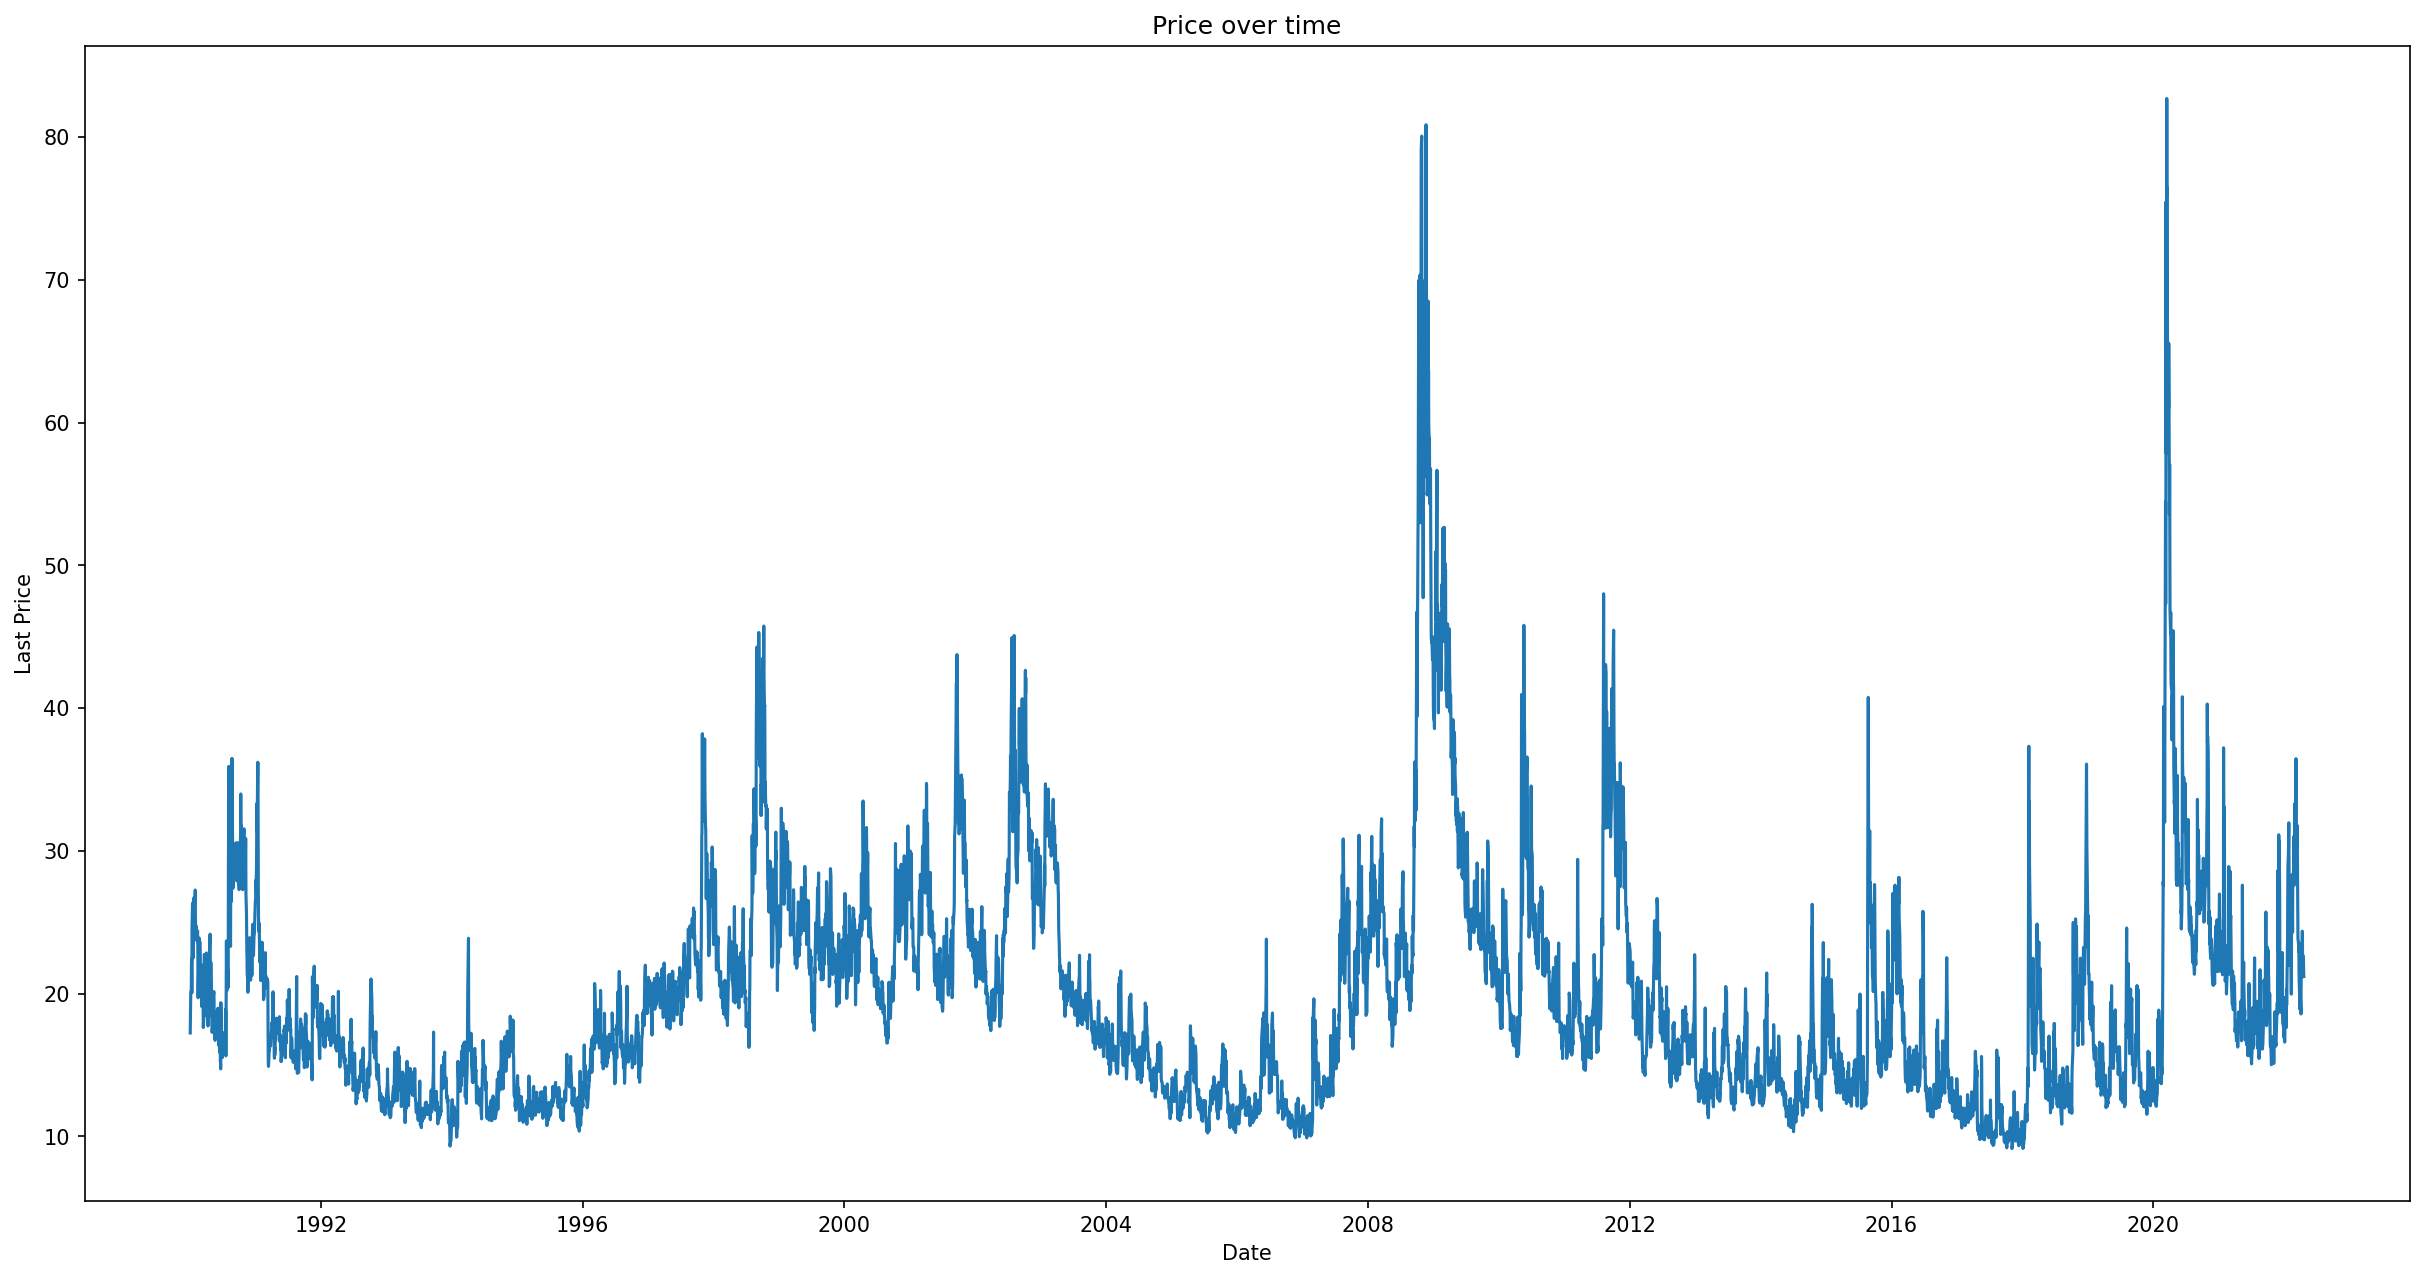

In [83]:
# plotting price over time to check frequency and trend
plt.figure(figsize=(20,10),dpi=150)
plt.plot(df.index, df['Last Price'], color ='tab:blue')
plt.gca().set(title='Price over time',
xlabel='Date', ylabel='Last Price')
plt.show()

In [84]:
#determine rolling statistics
#window size 12 denotes 12 months, giving rolling mean at yearly level
rolmean = df['Last Price'].rolling(window=12).mean()
rolstd = df['Last Price'].rolling(window=12).std()
print(rolmean, rolstd
      )

Date
2022-04-20          NaN
2022-04-19          NaN
2022-04-18          NaN
2022-04-14          NaN
2022-04-13          NaN
                ...    
1990-01-08    23.544167
1990-01-05    23.160000
1990-01-04    22.536667
1990-01-03    22.177500
1990-01-02    21.585833
Name: Last Price, Length: 8136, dtype: float64 Date
2022-04-20         NaN
2022-04-19         NaN
2022-04-18         NaN
2022-04-14         NaN
2022-04-13         NaN
                ...   
1990-01-08    2.108155
1990-01-05    2.286868
1990-01-04    2.253419
1990-01-03    2.579659
1990-01-02    2.839697
Name: Last Price, Length: 8136, dtype: float64


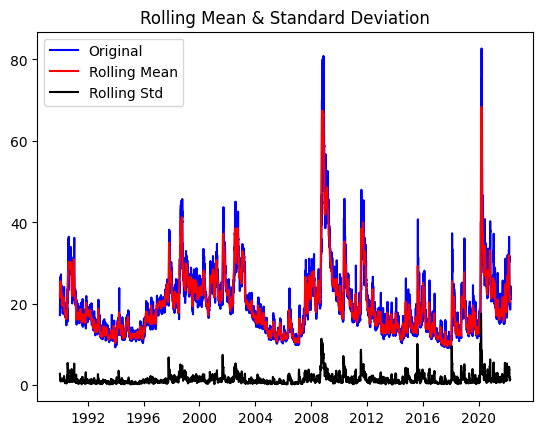

In [85]:
#plot rolling statistics
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show (block=False)

In [86]:
#perform augmented Dickey-Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Last Price'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -6.711864e+00
p-value                        3.663477e-09
#Lags Used                     1.000000e+01
Number of Observations Used    8.125000e+03
Critical Value (1%)           -3.431155e+00
Critical Value (5%)           -2.861896e+00
Critical Value (10%)          -2.566959e+00
dtype: float64


In [87]:
#calculating returns on price
Dataset_Return = df['Last Price'].pct_change()
Dataset_Return

,Last Price
Date,
2022-04-20,NaN
2022-04-19,0.008495
2022-04-18,0.037436
2022-04-14,0.023906
2022-04-13,-0.038767
...,...
1990-01-08,-0.087387
1990-01-05,-0.007404
1990-01-04,-0.044257


In [88]:
# calculating Log on Price column
Dataset_logScale = np.log(df['Last Price'])
Dataset_logScale

,Last Price
Date,
2022-04-20,3.053529
2022-04-19,3.061988
2022-04-18,3.098740
2022-04-14,3.122365
2022-04-13,3.082827
...,...
1990-01-08,3.008648
1990-01-05,3.001217
1990-01-04,2.955951


In [89]:
#calculating Log on Price column of Validation data
Valid_Dataset_logScale = np.log(df_Valid['Last Price'])
Valid_Dataset_logScale

,Last Price
Date,
2022-04-20,4.532008
2022-04-19,4.664005
2022-04-18,4.708629
2022-04-14,4.742756
2022-04-13,4.734091
...,...
2006-03-20,3.635742
2006-03-17,3.353407
2006-03-16,3.330059


<Axes: xlabel='Date'>

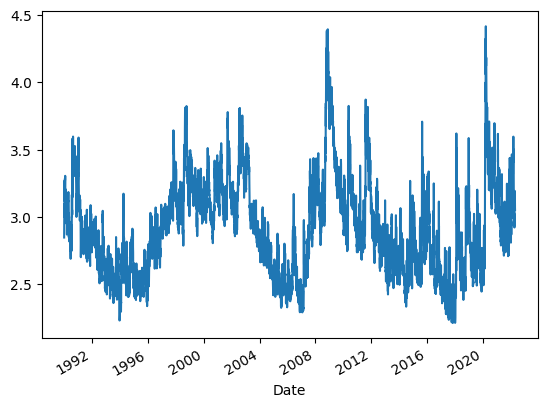

In [90]:
#plotting the logscale trend
Dataset_logScale.plot()

In [91]:
#Calculating Log Return on Log-Scale by taking log difference
Log_Return = Dataset_logScale.diff()
Log_Return

,Last Price
Date,
2022-04-20,NaN
2022-04-19,0.008459
2022-04-18,0.036752
2022-04-14,0.023625
2022-04-13,-0.039538
...,...
1990-01-08,-0.091444
1990-01-05,-0.007431
1990-01-04,-0.045266


In [92]:
#calculating Log Return on Validation data
Valid_Dataset_Log_Return = Valid_Dataset_logScale.diff()
Valid_Dataset_Log_Return

,Last Price
Date,
2022-04-20,NaN
2022-04-19,0.131997
2022-04-18,0.044624
2022-04-14,0.034127
2022-04-13,-0.008665
...,...
2006-03-20,0.015409
2006-03-17,-0.282336
2006-03-16,-0.023347


In [93]:
#Using log scale data
# normalizing the data
#copy the data
df_min_max_scaled = Log_Return.copy()

#apply normalization techniques on logged data

for i in df_min_max_scaled:
  df_min_max_scaled = (df_min_max_scaled - df_min_max_scaled.min()) / (df_min_max_scaled.max() - df_min_max_scaled.min())
# view normalized data

print(df_min_max_scaled)

Date
2022-04-20         NaN
2022-04-19    0.694208
2022-04-18    0.719497
2022-04-14    0.707764
2022-04-13    0.651310
                ...   
1990-01-08    0.604917
1990-01-05    0.680006
1990-01-04    0.646190
1990-01-03    0.637419
1990-01-02    0.638706
Name: Last Price, Length: 8136, dtype: float64


In [94]:
#normalising the validation data
#copy the data
V_df_min_max_scaled = Valid_Dataset_Log_Return.copy()

#apply normalisation techniques on logged data

for i in V_df_min_max_scaled:
  V_df_min_max_scaled = (V_df_min_max_scaled - V_df_min_max_scaled.min()) / (V_df_min_max_scaled.max() - V_df_min_max_scaled.min())

#view normlised data
print(V_df_min_max_scaled)

Date
2022-04-20         NaN
2022-04-19    0.352148
2022-04-18    0.311325
2022-04-14    0.306421
2022-04-13    0.286428
                ...   
2006-03-20    0.297676
2006-03-17    0.158564
2006-03-16    0.279568
2006-03-15    0.021469
2006-03-06    1.000000
Name: Last Price, Length: 3997, dtype: float64


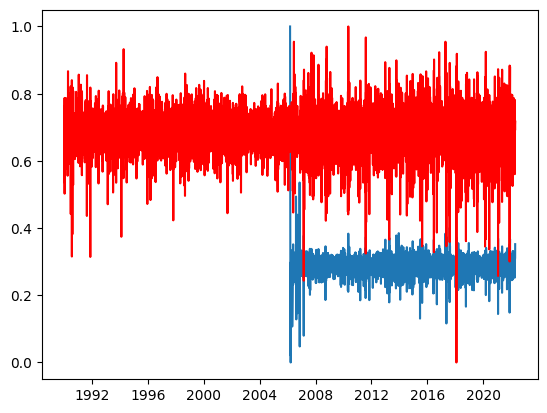

In [95]:
# plotting the original over validation data
plt.plot(V_df_min_max_scaled)
plt.plot(df_min_max_scaled, color='red')

From now on every testing data will be replaced by validation data so my testing data is an entirely different dataset called VXX. this way i am not overfitting on VIX series

ARIMA MODEL

In [96]:
# printing the data shpe
print(df_min_max_scaled.shape)

# make the train and test split
#iloc[:, -1] it means the last column, but df. iloc[:, :-1] means until the last column
train=df_min_max_scaled.iloc[:-30]
test= V_df_min_max_scaled.iloc[-30:]

# printing the data shape

print(train.shape, test.shape)

(8136,)
(8106,) (30,)


In [97]:
#fitting the ARIMA model on train data

model=ARIMA(train, order=(1, 0, 5))
model=model.fit()

# printing the model summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                 8106
Model:                 ARIMA(1, 0, 5)   Log Likelihood               11364.463
Date:                Mon, 08 Sep 2025   AIC                         -22712.926
Time:                        12:41:42   BIC                         -22656.923
Sample:                             0   HQIC                        -22693.770
                               - 8106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6866      0.000   1828.647      0.000       0.686       0.687
ar.L1          0.9091      0.024     37.209      0.000       0.861       0.957
ma.L1         -1.0066      0.026    -38.115      0.000      -1.058      -0.955
ma.L2          0.0270      0.011      2.504      0.012       0.006       0.048
ma.L3          0.0154      0.012      1.334      0.182      -0.007       0.038
ma.L4         -0.0075      0.012     -0.623      0.534      -0.031       0.016
ma.L5          0.0193      0.010      1.933      0.053      -0.000       0.039
sigma2         0.0035   3.15e-05    112.416      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             12217.59
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
 # print the fitted values (predicted values)

 data = model.fittedvalues
 data

,0
Date,
2022-04-20,0.686580
2022-04-19,0.686580
2022-04-18,0.685952
2022-04-14,0.683279
2022-04-13,0.682378
...,...
1990-02-20,0.678904
1990-02-16,0.684550
1990-02-15,0.692975


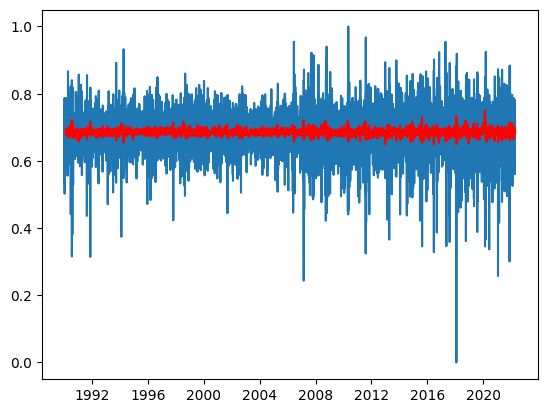

In [99]:
#plot the actual over predict data

plt.plot(df_min_max_scaled)
plt.plot(model.fittedvalues, color='red')

In [100]:
#calculating the difference
predictions_ARIMA_diff = pd.Series(model.fittedvalues - df_min_max_scaled)
print(predictions_ARIMA_diff)

Date
1990-01-02         NaN
1990-01-03         NaN
1990-01-04         NaN
1990-01-05         NaN
1990-01-08         NaN
                ...   
2022-04-13    0.031068
2022-04-14   -0.024485
2022-04-18   -0.033544
2022-04-19   -0.007628
2022-04-20         NaN
Length: 8136, dtype: float64


In [101]:
#convert to cumulative sum

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Date
1990-01-02         NaN
1990-01-03         NaN
1990-01-04         NaN
1990-01-05         NaN
1990-01-08         NaN
                ...   
2022-04-13   -1.072534
2022-04-14   -1.097019
2022-04-18   -1.130563
2022-04-19   -1.138191
2022-04-20         NaN
Length: 8136, dtype: float64


<Axes: xlabel='Date'>

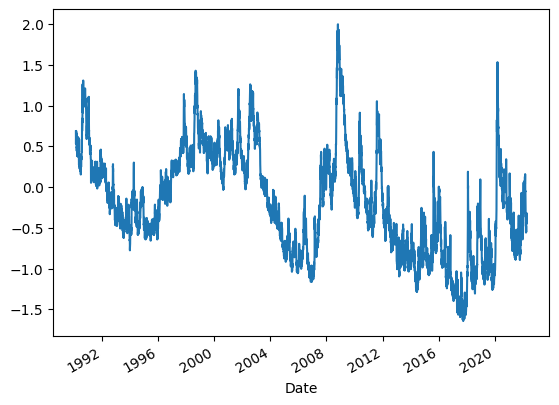

In [102]:
#plotting the predictive plot to check the over future trend

predictions_ARIMA_log = pd.Series(df_min_max_scaled, index=df_min_max_scaled.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)
predictions_ARIMA_log.plot()

In [103]:
# making a data frame of predicted values
final_data = pd.DataFrame(data, columns=['Price'])
final_data

,Price
Date,
2022-04-20,0.686580
2022-04-19,0.686580
2022-04-18,0.685952
2022-04-14,0.683279
2022-04-13,0.682378
...,...
1990-02-20,0.678904
1990-02-16,0.684550
1990-02-15,0.692975


GAN

In [104]:
#split into train and test sets
train_size = int(len(final_data) * 0.7)
test_size = train_size - len(V_df_min_max_scaled)
train = final_data[test_size:len(final_data)]
test = final_data[train_size:len(final_data)]
print(len(train), len(test))


6429 2432


In [105]:
# making the train data out of original dataframe

training_set = train.iloc[:].values
X_train = []
y_train = []
for i in range(100, training_set.shape[0]):
  X_train.append(training_set[i-100:i,0])
  y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [106]:
print(X_train.shape)
print(y_train.shape)

(6329, 100)
(6329,)


In [107]:
# make the testing data out of original dataframe

testing_set = test.iloc[:].values
X_test = []
y_test = []
for i in range(100, testing_set.shape[0]):
  X_test.append(testing_set[i-100:i,0])
  y_test.append(testing_set[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [108]:
print(X_test.shape)
print(y_test.shape
    )

(2332, 100)
(2332,)


In [109]:
# reshaping the dimension of X variable from 100 to 10*10
#Imagine that you have created an array with 100 dimensions
#and then you calculate something and fill this array. for
#whatever reason, you have not created 2d array, what is
#wrong with this question that you want to assign another
#dimension to this data, with this justification that for
#example 250 samples should have this calculated data?!!
#reshape() function shapes an array without changing the data of the array.
x_train = X_train.reshape(len(X_train), 10*10).astype('float32')
x_test = X_test.reshape(len(X_test), 10*10).astype('float32')
#augmented division. converting to 10x10 dimension by choosing only floats. then
#divide by 255 standard per pixel value. any value other than flot it should be left outside
x_train /= 255
x_test /= 255

In [110]:
# Data is currently flattened, we need to reshape it back to 10 * 10. to do that we reshape the data
# dataset is not altered after dividing it by 255
#numpy reshape to reshape the data and to automatically calculate the size of vector (rows x columns) and
#relocate it into a -1D vector with that dimension which is our case of single price column
x_train = np.reshape(x_train, [-1, 10, 10])
x_test = np.reshape(x_test, [-1, 10, 10])

In [111]:
# Gan model requires input of 32x32. so we will pad the train and test images with zeros to increase the size to 32x 32.
#already added 10*10 two times abovem while confirming float and leftovers.
#now to make symmetrical vectors, we will add 11, to adjust for symmetry.
x_train = np.pad(x_train, ((0,0), (11, 11), (11, 11)), 'constant')
x_test = np.pad(x_test, ((0,0), (11, 11), (11, 11)), 'constant')

In [112]:
# convolutional model requires input to be of 3 dimentions. we will add a channel dimension to it.
#becomes 3D data. basically (Data, 32, 32, 1) for cnn
x_train = np.reshape(x_train, [-1, 32, 32, 1])
x_test = np.reshape(x_test, [-1, 32, 32, 1])


In [113]:
# assigning variables

X_train = x_train

X_test = x_test

In [114]:
# overview
print(X_train.shape)
print(X_test.shape)

(6329, 32, 32, 1)
(2332, 32, 32, 1)


In [115]:
from keras.layers import LeakyReLU
def define_generator(latent_dim):
  init = RandomNormal(stddev=0.02)
  in_lat = Input(shape=(latent_dim))
  gen = TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(32,32,1)))
  gen = TimeDistributed(MaxPooling1D(2))
  gen = TimeDistributed(Conv1D(128, kernel_size=3, activation='relu'))
  gen = TimeDistributed(MaxPooling1D(2))
  gen = TimeDistributed(Conv1D(64, kernel_size=3, activation='relu'))
  gen = TimeDistributed(MaxPooling1D(2))
  #LSTM LAYERS
  gen = Bidirectional(LSTM(100, return_sequences=True))
  gen = Dropout(0.5)
  gen = Bidirectional(LSTM(100, return_sequences=False))
  gen = Dropout(0.5)
  gen = Dense(256, kernel_initializer=init)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dense(512, kernel_initializer=init)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dense(1024, kernel_initializer=init)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dense(32 * 32 * 1, kernel_initializer=init)(gen)
  #Final Layers
  out_layer = Activation('tanh')(gen)
  out_layer = Reshape((32, 32, 1))(gen)
  model = Model(in_lat, out_layer)
  opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']
                )
  return model

In [116]:
from numpy.random import randn
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input


In [117]:
def generate_real_samples(X_train, n_samples):
  ix = randint(0, X_train.shape[0], n_samples)
  X = X_train[ix]
  y = ones((n_samples, 1))
  return X, y

In [118]:
def generate_fake_samples(generator, latent_dim, n_samples):
  z_input = generate_latent_points(latent_dim, n_samples)
  images = generator.predict(z_input)
  y = zeros((n_samples, 1))
  return images, y

In [119]:
def summarize_performance(step, g_model, latent_dim, n_samples =100):
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  X = (X + 1) / 2.0
  for i in range(100):
    pyplot.subplot(10, 10, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
  filename2 = 'model_%04d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s' % (filename2))

In [120]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
     pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
     pyplot.axis('off')
     pyplot.imshow(examples[i, :, :, 0], cmap = 'gray_r')
     pyplot.imshow(examples[i, :, :, 0], cmap = 'gray_r')
    pyplot.show()

In [121]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from tensorflow.keras.layers import Input


def define_discrimator(in_shape=(32, 32, 1)):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=in_shape)

  #define the model
  model = Sequential()
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid')) # Use sigmoid for binary classification

  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [122]:
discriminator = define_discrimator()

In [123]:
from keras.layers import LeakyReLU, Conv2DTranspose, Reshape
def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    # Foundation for 4x4 image
    n_nodes = 128 * 4 * 4
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 128))(gen)
    # Upsampling to 8x8
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # Upsampling to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # Upsampling to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # Output layer
    out_layer = Conv2D(1, (3,3), activation='tanh', padding='same', kernel_initializer=init)(gen)
    model = Model(in_lat, out_layer)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [124]:
generator = define_generator(100)

In [125]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [126]:
gan_model = define_gan(generator, discriminator)

In [127]:
def train(g_model, d_model, gan_model, X_train, laten_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        # Reshape y_real to match discriminator output shape
        y_real = y_real.reshape(-1, 1)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)

        X_fake, y_fake = generate_fake_samples(g_model, laten_dim, n_batch)
        # Reshape y_fake to match discriminator output shape
        y_fake = y_fake.reshape(-1, 1)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)

        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%3f]' % (i+1, d_loss_r, d_acc_r, d_loss_f, d_acc_f, g_loss, g_acc ))
        if (i+1) % (bat_per_epo * 1) == 0:
          summarize_performance(i, g_model, latent_dim)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
>1, dr[0.693,0.391], df[0.693,0.320], g[0.693,0.671875]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>2, dr[0.693,0.359], df[0.693,0.320], g[0.693,0.718750]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>3, dr[0.693,0.334], df[0.693,0.302], g[0.693,0.781250]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>4, dr[0.693,0.319], df[0.693,0.285], g[0.693,0.824219]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>5, dr[0.693,0.280], df[0.693,0.256], g[0.693,0.853125]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>6, dr[0.693,0.254], df[0.693,0.234], g[0.693,0.875000]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>7, dr[0.693,0.240], df[0.693,0.228], g[0.693,0.892857]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>8, dr[0.693,0.233], df[0.693,0.219], g[0.693,0.902344]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>9, dr[0.693,0.226], df[0.693,0.214], g[0.693,0.913194]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>10, dr[0.693,0.222], df[0.693,0.212], g[0.693,0.920313]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>11, dr[0.693,0.218]

>Saved: model_0098.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>99, dr[0.718,0.189], df[0.719,0.188], g[0.646,0.980114]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>100, dr[0.718,0.189], df[0.719,0.188], g[0.645,0.980312]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>101, dr[0.719,0.188], df[0.719,0.188], g[0.645,0.980507]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>102, dr[0.719,0.188], df[0.719,0.187], g[0.645,0.980699]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>103, dr[0.719,0.188], df[0.719,0.187], g[0.644,0.980886]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>104, dr[0.719,0.188], df[0.720,0.187], g[0.644,0.981070]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>105, dr[0.720,0.188], df[0.720,0.187], g[0.643,0.981250]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>106, dr[0.720,0.188], df[0.720,0.187], g[0.643,0.981427]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>107, dr[0.720,0.188], df[0.720,0.188], g[0.643,0.981600]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>108, dr[0.720,0.189], df[0.721,0.188], g[0.642,0.981771]
2/2 ━━━━━━━━━━━━━━━

>Saved: model_0196.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>197, dr[0.735,0.186], df[0.735,0.185], g[0.617,0.990006]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>198, dr[0.735,0.186], df[0.736,0.185], g[0.617,0.990057]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>199, dr[0.735,0.186], df[0.736,0.186], g[0.617,0.990107]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>200, dr[0.736,0.186], df[0.736,0.186], g[0.616,0.990156]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>201, dr[0.736,0.186], df[0.736,0.185], g[0.616,0.990205]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>202, dr[0.736,0.186], df[0.736,0.185], g[0.616,0.990254]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>203, dr[0.736,0.186], df[0.736,0.185], g[0.616,0.990302]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>204, dr[0.736,0.185], df[0.736,0.185], g[0.616,0.990349]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>205, dr[0.736,0.186], df[0.736,0.185], g[0.615,0.990396]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>206, dr[0.736,0.186], df[0.737,0.185], g[0.615,0.990443]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0294.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>295, dr[0.746,0.185], df[0.746,0.184], g[0.599,0.993326]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>296, dr[0.746,0.185], df[0.746,0.184], g[0.599,0.993349]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>297, dr[0.746,0.185], df[0.746,0.184], g[0.599,0.993371]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>298, dr[0.746,0.185], df[0.747,0.184], g[0.599,0.993393]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>299, dr[0.746,0.184], df[0.747,0.184], g[0.599,0.993416]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>300, dr[0.747,0.185], df[0.747,0.184], g[0.599,0.993437]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>301, dr[0.747,0.184], df[0.747,0.184], g[0.599,0.993459]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>302, dr[0.747,0.185], df[0.747,0.184], g[0.598,0.993481]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>303, dr[0.747,0.185], df[0.747,0.184], g[0.598,0.993502]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>304, dr[0.747,0.185], df[0.747,0.184], g[0.598,0.993524]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0392.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>393, dr[0.753,0.184], df[0.753,0.184], g[0.588,0.994990]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>394, dr[0.753,0.184], df[0.754,0.184], g[0.588,0.995003]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>395, dr[0.753,0.184], df[0.754,0.184], g[0.588,0.995016]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>396, dr[0.753,0.184], df[0.754,0.184], g[0.588,0.995028]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>397, dr[0.754,0.184], df[0.754,0.184], g[0.588,0.995041]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>398, dr[0.754,0.184], df[0.754,0.184], g[0.587,0.995053]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>399, dr[0.754,0.184], df[0.754,0.184], g[0.587,0.995066]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>400, dr[0.754,0.184], df[0.754,0.184], g[0.587,0.995078]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>401, dr[0.754,0.184], df[0.754,0.184], g[0.587,0.995090]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>402, dr[0.754,0.184], df[0.754,0.184], g[0.587,0.995103]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0490.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>491, dr[0.758,0.183], df[0.758,0.183], g[0.580,0.995990]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>492, dr[0.758,0.183], df[0.758,0.183], g[0.580,0.995999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>493, dr[0.758,0.183], df[0.758,0.183], g[0.580,0.996007]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>494, dr[0.758,0.183], df[0.758,0.183], g[0.580,0.996015]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>495, dr[0.758,0.183], df[0.758,0.183], g[0.580,0.996023]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>496, dr[0.758,0.183], df[0.758,0.183], g[0.580,0.996031]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>497, dr[0.758,0.183], df[0.758,0.183], g[0.580,0.996039]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
>498, dr[0.758,0.183], df[0.759,0.183], g[0.580,0.996047]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>499, dr[0.758,0.183], df[0.759,0.183], g[0.580,0.996055]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>500, dr[0.758,0.183], df[0.759,0.183], g[0.580,0.996063]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0588.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>589, dr[0.762,0.183], df[0.762,0.183], g[0.575,0.996657]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>590, dr[0.762,0.183], df[0.762,0.183], g[0.575,0.996663]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>591, dr[0.762,0.183], df[0.762,0.183], g[0.575,0.996669]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>592, dr[0.762,0.183], df[0.762,0.183], g[0.575,0.996674]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>593, dr[0.762,0.183], df[0.762,0.183], g[0.574,0.996680]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>594, dr[0.762,0.183], df[0.762,0.183], g[0.574,0.996686]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>595, dr[0.762,0.183], df[0.762,0.183], g[0.574,0.996691]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>596, dr[0.762,0.183], df[0.762,0.183], g[0.574,0.996697]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>597, dr[0.762,0.183], df[0.762,0.183], g[0.574,0.996702]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>598, dr[0.762,0.183], df[0.762,0.183], g[0.574,0.996708]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0686.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>687, dr[0.764,0.183], df[0.764,0.183], g[0.570,0.997134]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>688, dr[0.764,0.183], df[0.764,0.183], g[0.570,0.997138]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>689, dr[0.764,0.183], df[0.764,0.183], g[0.570,0.997143]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>690, dr[0.764,0.183], df[0.765,0.183], g[0.570,0.997147]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>691, dr[0.764,0.183], df[0.765,0.183], g[0.570,0.997151]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>692, dr[0.764,0.183], df[0.765,0.183], g[0.570,0.997155]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>693, dr[0.764,0.183], df[0.765,0.183], g[0.570,0.997159]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>694, dr[0.765,0.183], df[0.765,0.183], g[0.570,0.997163]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>695, dr[0.765,0.183], df[0.765,0.183], g[0.570,0.997167]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>696, dr[0.765,0.183], df[0.765,0.183], g[0.570,0.997171]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0784.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>785, dr[0.766,0.184], df[0.767,0.183], g[0.567,0.997492]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>786, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997495]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>787, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997498]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>788, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997502]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>789, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997505]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>790, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997508]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>791, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997511]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>792, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997514]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>793, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997517]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>794, dr[0.767,0.184], df[0.767,0.183], g[0.567,0.997521]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0882.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>883, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997770]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>884, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997773]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>885, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997775]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>886, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997778]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>887, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997780]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>888, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997783]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>889, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997785]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>890, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997788]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>891, dr[0.768,0.184], df[0.768,0.184], g[0.564,0.997790]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
>892, dr[0.768,0.184], df[0.769,0.184], g[0.564,0.997793]
2/2 ━━━━━━━━━━━━━━

>Saved: model_0980.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>981, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.997993]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>982, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.997995]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>983, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.997997]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>984, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.997999]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>985, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.998001]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>986, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.998003]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>987, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.998005]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>988, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.998007]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>989, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.998009]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
>990, dr[0.770,0.184], df[0.770,0.184], g[0.562,0.998011]
2/2 ━━━━━━━━━━━━━━

>Saved: model_1078.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
>1079, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998175]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1080, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998177]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1081, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998179]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1082, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998180]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1083, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998182]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>1084, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998184]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1085, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998186]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1086, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998187]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1087, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998189]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
>1088, dr[0.771,0.183], df[0.771,0.183], g[0.560,0.998190]
2/2 ━━━━

>Saved: model_1176.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
>1177, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998327]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1178, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998329]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>1179, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998330]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
>1180, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998332]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1181, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998333]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1182, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998334]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>1183, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998336]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
>1184, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998337]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>1185, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998339]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>1186, dr[0.772,0.183], df[0.772,0.183], g[0.558,0.998340]
2/2 ━━━━

>Saved: model_1274.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>1275, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998456]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1276, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998457]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>1277, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998458]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>1278, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998460]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
>1279, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998461]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1280, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998462]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1281, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998463]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1282, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998464]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
>1283, dr[0.773,0.182], df[0.773,0.182], g[0.557,0.998465]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1284, dr[0.773,0.183], df[0.773,0.182], g[0.557,0.998467]
2/2 ━━━━

>Saved: model_1372.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
>1373, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998566]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>1374, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998567]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
>1375, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998568]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1376, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998569]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1377, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998570]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1378, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998571]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1379, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998572]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1380, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998573]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1381, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998574]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1382, dr[0.774,0.182], df[0.774,0.182], g[0.555,0.998575]
2/2 ━━━━

>Saved: model_1470.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1471, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998662]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1472, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998663]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1473, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998663]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>1474, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998664]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1475, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998665]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1476, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998666]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1477, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998667]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1478, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998668]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1479, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998669]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1480, dr[0.775,0.182], df[0.775,0.182], g[0.554,0.998670]
2/2 ━━━━

>Saved: model_1568.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1569, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998745]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1570, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998746]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1571, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998747]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1572, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998748]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1573, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998748]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1574, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998749]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1575, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998750]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1576, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998751]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>1577, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998752]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1578, dr[0.775,0.182], df[0.775,0.182], g[0.553,0.998752]
2/2 ━━━━

>Saved: model_1666.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1667, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998819]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1668, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998820]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1669, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998820]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1670, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998821]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1671, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998822]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1672, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998823]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1673, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998823]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1674, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998824]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1675, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998825]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
>1676, dr[0.776,0.182], df[0.776,0.182], g[0.552,0.998825]
2/2 ━━━━

>Saved: model_1764.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1765, dr[0.776,0.182], df[0.777,0.182], g[0.552,0.998885]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1766, dr[0.777,0.182], df[0.777,0.182], g[0.552,0.998885]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1767, dr[0.777,0.182], df[0.777,0.182], g[0.552,0.998886]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1768, dr[0.777,0.182], df[0.777,0.182], g[0.552,0.998887]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1769, dr[0.777,0.182], df[0.777,0.182], g[0.552,0.998887]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1770, dr[0.777,0.182], df[0.777,0.182], g[0.552,0.998888]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1771, dr[0.777,0.182], df[0.777,0.182], g[0.552,0.998888]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1772, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998889]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1773, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998890]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1774, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998890]
2/2 ━━━━

>Saved: model_1862.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>1863, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998943]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1864, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998944]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1865, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998944]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1866, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998945]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1867, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998945]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1868, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998946]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1869, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998947]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1870, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998947]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1871, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998948]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1872, dr[0.777,0.182], df[0.777,0.182], g[0.551,0.998948]
2/2 ━━━━

>Saved: model_1960.h5


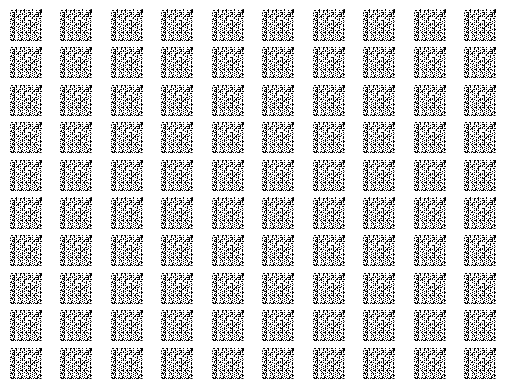

In [128]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

In [129]:
model = load_model('model_1960.h5')
latent_dim = 100
n_examples = 5574
latent_points = generate_latent_points(latent_dim, n_examples)
X = model.predict(latent_points)
X = (X + 1) / 2.0

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [130]:
 #plot the GAN model
 #plot_model(gan_model, to_file = 'gan_plot.png', show_shapes=True, show_layer_names=True) # Removed plot_model call

In [131]:
X.shape

(5574, 32, 32, 1)

In [132]:
#split into train and test sets
train_size = int(len(final_data) * 0.7)
test_size = len(final_data) - train_size
train = final_data[test_size:len(final_data)]
test = final_data[train_size:len(final_data)]
print(len(train), len(test))

#making the training data out of original dataframe

training_set = train.iloc[:].values
X_train = []
y_train = []
for i in range(100, training_set.shape[0]):
  X_train.append(training_set[i-100:i, 0])
  y_train.append(training_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

#making the testubg data out of original dataframe

testing_set = test.iloc[:].values
X_test = []
y_test = []
for i in range(100, testing_set.shape[0]):
  X_test.append(testing_set[i-100:i, 0])
  y_test.append(testing_set[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

5674 2432


In [133]:
# save the model for the future use as it takes hours to be trained
model.save('alexfruit.h5')

In [136]:
#pick the first fully connected layer as the features which will be of dimension (1 x 100)
layer_name = 'dense_3'
FC_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [137]:
#find the features for n number of train images and we will get nx100
#this means we will get 100 features for each value
i=0
features = np.zeros(shape=(X_train.shape[0], 100))
for directory_path in glob.glob("Examples/Trainexample1/*"):
  for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (227, 227))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img, axis=0)
    FC_output = FC_layer_model.predict(img)
    features[i] = FC_output
    i+=1

In [138]:
#save the features of the train images to use it in the future
np.save('features', features)

In [139]:
# name the feature rows as f_, f_1, f_2...
feature_col=[]
for i in range(100):
  feature_col.append("f_"+str(i))
  i+=1

In [140]:
#create dataframe with features and column name
train_features=pd.DataFrame(data=X_train, columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(y_train))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', y_train.shape)
train_class

Training Features Shape: (5574, 100)
Training Labels Shape: (5574,)


[np.float64(0.654540764998066),
 np.float64(0.6567988714474043),
 np.float64(0.6575977456832015),
 np.float64(0.6580641358528596),
 np.float64(0.6581813439104283),
 np.float64(0.658765130195144),
 np.float64(0.65967119374916),
 np.float64(0.6598731721486104),
 np.float64(0.6606886943637217),
 np.float64(0.6611465541793812),
 np.float64(0.6615918198091173),
 np.float64(0.6620168384569249),
 np.float64(0.6620749886702217),
 np.float64(0.6624223213332049),
 np.float64(0.6626493905682402),
 np.float64(0.6632654340019376),
 np.float64(0.6633193770739211),
 np.float64(0.6643808611509987),
 np.float64(0.6644720408235915),
 np.float64(0.6646065801897741),
 np.float64(0.6646884400744791),
 np.float64(0.6655805419248031),
 np.float64(0.6658415024293022),
 np.float64(0.6658960230495803),
 np.float64(0.6661368810570726),
 np.float64(0.6661518514686126),
 np.float64(0.6661520637064331),
 np.float64(0.666684192087509),
 np.float64(0.6666843824985321),
 np.float64(0.6670395095394825),
 np.float64(0.6

Random Forest

In [141]:
# define the model
rf = RandomForestRegressor(n_estimators=30, verbose=2, random_state=42, n_jobs = -1 )

In [142]:
# printing the model parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 30,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}

In [143]:
y_test.shape

(2332,)

In [144]:
# feed the extracted features with the labels to RANDOM FOREST
rf.fit(train_features, y_train)


building tree 1 of 30
building tree 2 of 30


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.4s finished


RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=42, verbose=2)

In [145]:
# find the features from Alexnet's FC layer for n number of test images and we will get n x 100
#The glob. glob returns the list of files with their full path (unlike os. listdir()) and is more powerful than os. listdir that does not use wildcards
i = 0
features_test = np.zeros(shape=(y_test.shape[0], 100))
for directory_path in glob.glob("Example/Validation-Example1//*"):
  for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (227, 227))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img, axis=0)
    FC_output = FC_layer_model.predict(img)
    features_test[i]=FC_output
    i+=1


In [146]:
# create dataframe with features and column name
test_features=pd.DataFrame(data=features_test, columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', y_test.shape)

Test Features Shape: (2332, 100)
Test Labels Shape: (2332,)


In [147]:
# feed the features of the test images to Random Forest Classifier to predict its class
predictions = rf.predict(test_features)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


In [148]:
features_test.shape

(2332, 100)

In [149]:
print('Random Forrest Model score Percentage:', rf.score(train_features, y_train)*100)

Random Forrest Model score Percentage: 91.64905073231083


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


In [150]:
print('MAPE:', mean_absolute_percentage_error(y_test, predictions))

MAPE: 0.010254858646080837


In [151]:
print('MAE:', MAE(y_test, predictions))

MAE: 0.007004750128156534


SVM

In [152]:
 # define the model and parameters
 svr_linear = SVR(kernel='linear', C=0.5, gamma=5, epsilon=0.01)
 parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
 ## using grid cv approach
 SVM = GridSearchCV(svr_linear, parameters)

In [153]:
# overview of parameters
SVM.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__C': 0.5,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.01,
 'estimator__gamma': 5,
 'estimator__kernel': 'linear',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVR(C=0.5, epsilon=0.01, gamma=5, kernel='linear'),
 'n_jobs': None,
 'param_grid': {'kernel': ('linear', 'rbf'), 'C': [1, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [154]:
# fitting the model on train data
SVM.fit(train_features, y_train)

GridSearchCV(estimator=SVR(C=0.5, epsilon=0.01, gamma=5, kernel='linear'),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [155]:
# model the score on train

In [156]:
# making predictions
predicted_SVM = SVM.predict(train_features)

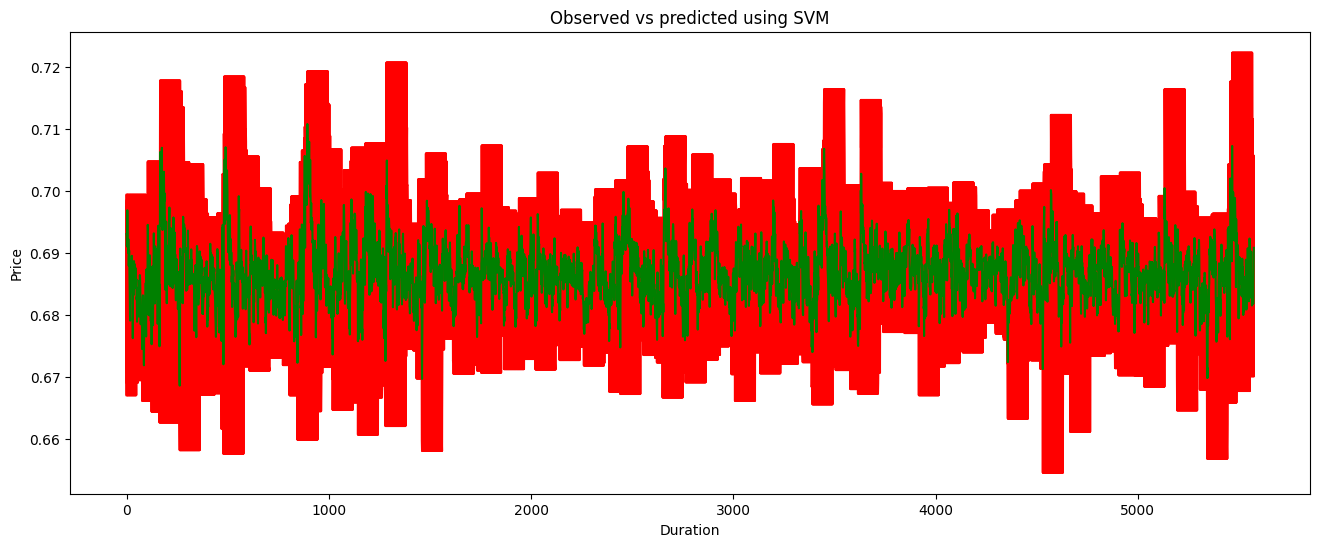

In [157]:
#Visualising the results
plt.figure(figsize=(16,6))
plt.plot(train_features, color = 'red')
plt.plot(predicted_SVM, color = 'green')
plt.title('Observed vs predicted using SVM')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()

In [158]:
print('MAPE:', mean_absolute_percentage_error(y_train, predicted_SVM))

MAPE: 0.005852906389988713


In [159]:
print('MAE:', MAE(y_train, predicted_SVM))

MAE: 0.004015958207032946


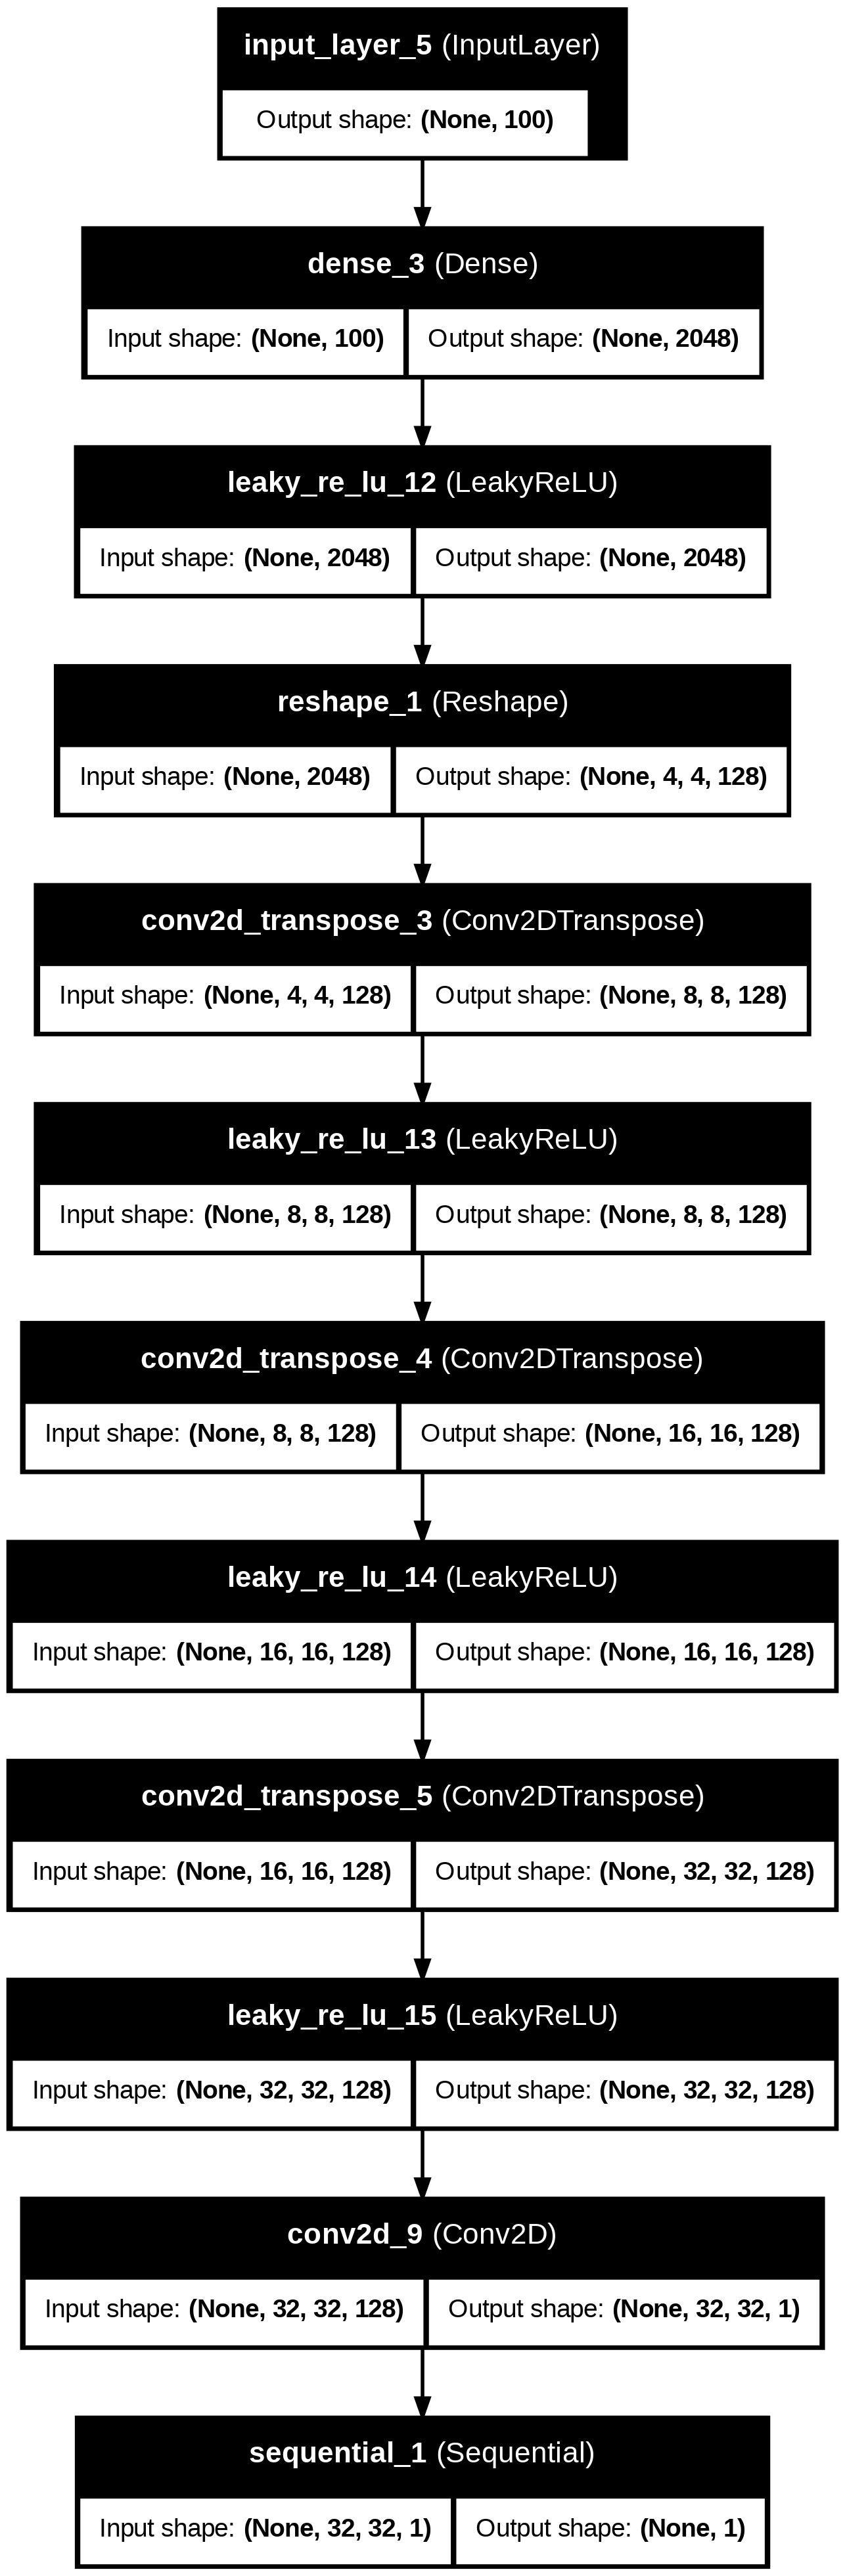

In [160]:
# Visualize the GAN model using tf.keras.utils.plot_model
tf.keras.utils.plot_model(gan_model, to_file='gan_plot_tf.png', show_shapes=True, show_layer_names=True)